# Урок 6. Градиентный бустинг. AdaBoost.

В этом уроке мы продолжаем тему ансамблей алгоритмов, рассматривая еще один их вид - _градиентный бустинг_. 

Вспоминая тему предыдущего урока, случайные леса, напомним, что случайный лес - это ансамбль деревьев небольшой глубины, строящихся независимо друг от друга. В независимости построения деревьев **кроется и плюс, и минус алгоритма**: с одной стороны, построение деревьев **можно распараллеливать** и, например, организовывать на разных ядрах процессора, с другой стороны, следствием их независимости является тот факт, что **для решения сложных задач требуется очень большое количество деревьев**. В этих случаях (при большой выборке или большом количестве признаков) обучение случайного леса может требовать очень много ресурсов, а если для ограничения их потребления слишком ограничивать глубину деревьев, они могут не уловить все закономерности в данных и иметь большой сдвиг (и, следовательно, ошибку).

**Бустинг** является своеобразным решением этой проблемы: он заключается в последовательном построении ансамбля, когда деревья **строятся одно за другим**, и при этом каждое следующее дерево строится таким образом, чтобы исправлять ошибки уже построенного на данный момент ансамбля. При таком подходе базовые алгоритмы могут быть достаточно простыми, то есть можно использовать неглубокие деревья.

## Алгоритм градиентного бустинга (GBM)

Итоговый алгоритм ищется в виде взвешенной суммы базовых алгоритмов (обратите внимание: не среднего, а суммы):

$$a_{N}(x) = \sum^{N}_{n=1}\gamma_{n}b_{n}(x).$$

В случае линейной регрессии задача состоит в минимизации среднеквадратичного функционала ошибки:

$$\frac{1}{l}\sum_{i=1}^{l}(a(x_{i}) - y_{i})^{2} \rightarrow \text{min}.$$

Так как ансамбль строится итеративно, нужно вначале обучить первый простой алгоритм (к примеру, решающее дерево), минимизирующий функционал ошибки:

$$b_{1}(x) = \underset{b}{\text{argmin}}\frac{1}{l}\sum_{i=1}^{l}(b(x_{i}) - y_{i})^{2}.$$

Как мы помним, такая задача легко решается методом градиентного спуска.

После того, как мы нашли первый алгоритм $b_{1}(x)$, нам нужно добавить в ансамбль еще один алгоритм $b_{2}(x)$. Для начала найдем разницу ответов первого алгоритма с реальными ответами:

$$s_{i}^{(1)} = y_{i} - b_{1}(x_{i}).$$

Если прибавить эти значения к полученным предсказаниям, получим идеальный ответ. Таким образом, новый алгоритм логично обучать так, чтобы его ответы были максимально близки к этой разнице, чтобы при их прибавлении к ответам первого алгоритма мы получили близкие к реальным. Значит, второй алгоритм будет обучаться на следующем функционале ошибки:

$$b_{2}(x) = \underset{b}{\text{argmin}}\frac{1}{l}\sum_{i=1}^{l}(b(x_{i}) - s_{i}^{(1)})^{2} = \underset{b}{\text{argmin}}\frac{1}{l}\sum_{i=1}^{l}(b(x_{i}) - (y_{i} - b_{1}(x_{i})))^{2}.$$

<img src="data/boosting_sum.png" style="width: 500px;">

Каждый следующий алгоритм также настраивается на остатки композиции из предыдущих алгоритмов:

$$b_{N}(x) = \underset{b}{\text{argmin}}\frac{1}{l}\sum_{i=1}^{l}(b(x_{i}) - s_{i}^{(N)})^{2},$$ 

$$s_{i}^{(N)} = y_{i} - \sum_{n=1}^{N-1}b_{n}(x_{i}) = y_{i} - a_{N-1}(x_{i}).$$

Таким образом, каждый новый алгоритм корректирует ошибки предыдущих, и так продолжается до момента получения приемлемой ошибки на композиции. Вектор коэффициентов $s$ при этом называют _вектором сдвига_.

<img src="data/error.png" style="width: 500px;">

Выбор сдвига из условия $s_{i} = y_{i} - a_{N-1}(x_{i})$ требует точного совпадения полученных предсказаний и ответов, однако, в более общем случае вектор сдвига принимают с учетом особенностей используемой в данном случае функции потерь: вектор сдвига должен ее минимизировать, то есть направлять в сторону уменьшения. Как мы помним из метода градиентного спуска, направление наискорейшего убывания функции совпадает с ее антиградиентом. Таким образом, если при обучении мы минимизируем функционал ошибки $L(y,z)$

$$\sum_{i=1}^{l}L(y_{i}, a_{N-1}(x_{i}) + s_{i}) \rightarrow \underset{s}{\text{min}},$$

сдвиг на каждом шаге должен быть противоположен производной функции потерь в точке $z = a_{N-1}(x_{i})$. 

$$s_{i} = \left.-\frac{\partial L}{\partial z} \right|_{z = a_{N-1}(x_{i})}.$$

Каждый новый алгоритм таким образом выбирается, чтобы как можно лучше приближать антиградиент ошибки на обучающей выборке. 

После того, как мы вычислили требуемый для минимизации ошибки сдвиг $s$, нужно настроить алгоритм $b_{N}(x)$ так, чтобы он давал максимально близкие к нему ответы, то есть обучать его именно на вектор сдвига. Близость ответов алгоритма к сдвигу обычно оценивается с помощью среднеквадратичной ошибки независимо от условий исходной задачи (так как исходно используемая функция потерь $L$ уже учтена в сдвигах $s_{i}$):

$$b_{N}(x) = \underset{s}{\text{argmin}}\frac{1}{l}\sum_{i=1}^{l}(b(x_{i})-s_{i})^{2}.$$

Коэффициент $\gamma$ для найденного алгоритма также находится по аналогии с наискорейшим градиентным спуском:

$$\gamma_{N} = \underset{\gamma}{\text{argmin}}\sum_{i=1}^{l}L(y_{i},a_{N-1}(x_{i}) + \gamma b_{N}(x_{i})).$$

Обычно в качестве функции потерь в задачах регрессии принимается квадратичная функция потерь ($L_{2}$ loss):

$$L(y, z) = (y-z)^{2},$$

его производная по $z$ примет вид 

$$L'(y, z) = 2(z-y)$$

или модуль отклонения ($L_{1}$ loss)

$$L(y, z) = |y-z|,$$

его производная по $z$ будет иметь вид 

$$L'(y, z) = \text{sign}(z-y).$$

В случае классификации - логистическая функция потерь:

$$L(y, z) = log(1 + exp(-yz))$$

ее производная:

$$L'(y, z) = \frac{y_{i}}{1+exp(-yz)}.$$

Следует помнить, что компоненты $s_{i}$, вычисляемые через эти производные, берутся с минусом.

Аналогично алгоритму градиентного спуска, имеет смысл добавлять ответ каждого нового алгоритма не полностью, а с некоторым шагом $\eta \in (0, 1]$, так как базовые алгоритмы обычно достаточно простые (например, деревья малой глубины), и они могут плохо приближать вектор антиградиента, и тогда вместо приближения к минимуму мы будем получать случайное блуждание в пространстве. В градиентном бустинге такой прием называется сокращением шага.

$$a_{N}(x) = a_{N-1}(x) + \eta \gamma_{N} b_{N}(x).$$

Градиентный бустинг склонен к переобучению при увеличении числа итераций $N$ или глубины входящих в него деревьев. Стоит об этом помнить при построении алгоритма и выбирать оптимальные параметры по отложенной выборке или с помощью кросс-валидации.

В конечном итоге **алгоритм построения модели градиентного бустинга** заключается в следующих шагах:

__1.__ Для инициализации выбирается произвольный простой алгоритм $b_{0}(x)$, в его роли можно брать обычные константные алгоритмы: в случае задачи регрессии это может быть

$$b_{0}(x) = 0$$

или среднее значение по всем объектам обучающей выборки 

$$b_{0}(x) = \frac{1}{l}\sum_{i=1}^{l}y_{i};$$

в случае классификации - самый часто встречающийся в выборке класс

$$b_{0}(x) = \underset{y}{\text{argmax}}\sum_{i=1}^{l}[y_{i} = y].$$

или строим простые деревья.

__2.__ Для каждой итерации вычисляется вектор сдвига $s$:

$$s = \left ( \left.-\frac{\partial L}{\partial z} \right|_{z = a_{n-1}(x_{1})},...,\left.-\frac{\partial L}{\partial z} \right|_{z = a_{n-1}(x_{l})}\right );$$
*(градиент функции потерь в точке z, z - алгоритмы, которые построили до этого шага. Пример: на 2ом шаге точка z - алгоритм 1ого шага, на 3ем шаге z - сумма алгоритмов 1 и 2 шага с весами)*

находится алгоритм

$$b_{n}(x) = \underset{s}{\text{argmin}}\frac{1}{l}\sum_{i=1}^{l}(b(x_{i})-s_{i})^{2};$$
*(ошибка MSE в данном примере)*

находится оптимальный коэффициент $\gamma$

$$\gamma_{n} = \underset{\gamma}{\text{argmin}}\sum_{i=1}^{l}L(y_{i},a_{n-1}(x_{i}) + \gamma b_{n}(x_{i})).$$

и добавляется в имеющийся ансамбль с умножением на шаг $\eta$, называемый _скоростью обучения_ (shrinkage)

$$a_{n}(x) = a_{n-1}(x) + \eta \gamma_{n} b_{n}(x).$$

__3.__ При достижении критериев остановки компонуется итоговая модель.

### Стохастический градиентный бустинг

Как и в случае с градиентым спуском, есть так называемый стохастический градиентный бустинг, являющийся упрощенной (в плане потребления ресурсов) версией алгоритма. Его суть заключается в обучении каждого нового базового алгоритма на новой итерации не на всей обучающей выборке, а на некоторой ее случайной подвыборке. Практика показывает, что такой алгоритм позволяет получить такую же ошибку или даже уменьшить ее при том же числе итераций, что и в случае использования обычного бустинга.

**Будет в ДЗ**

In [ ]:
12:00

## Реализация алгоритма градиентного бустинга

Реализуем средствами Python алгоритм градиентного бустинга для деревьев решений.

Реализация деревьев решений была дважды продемонстрирована в предыдущих уроках, в этом не будем ее повторять и возьмем готовую реализацию дерева решений для регрессии из библиотеки `sklearn`.

In [1]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

Используем один из "игрушечных" датасетов из той же библиотеки.

In [2]:
from sklearn.datasets import load_diabetes

In [3]:
X, y = load_diabetes(return_X_y=True)

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Напишем функцию, реализующую предсказание в градиентном бустинге
$$a_{N}(x) = \sum^{N}_{n=1}\gamma_{n}b_{n}(x).$$

In [5]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [6]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y-z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z-y)$. Реализуем ее также в виде функции (коэффициент 2 можно отбросить).

In [7]:
def bias(y, z):
    return (y - z)

Реализуем функцию обучения градиентного бустинга.

In [8]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        # базовый алгоритм
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

Теперь обучим несколько моделей с разными параметрами и исследуем их поведение.

In [9]:
# Число деревьев в ансамбле
n_trees = 10

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [10]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

In [11]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тренировочной выборке: 1181.6102944435008
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тестовой выборке: 4899.0215293321335


Построим графики зависимости ошибки на обучающей и тестовой выборках от числа итераций.

In [12]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [13]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

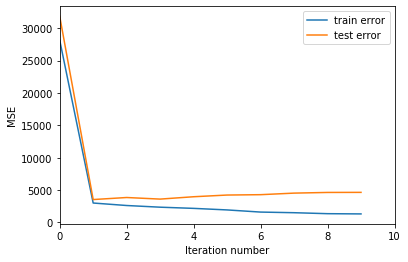

In [14]:
get_error_plot(n_trees, train_errors, test_errors)

Такой результат не является удовлетворительным

Увеличим число деревьев.

In [15]:
%%time
n_trees = 50
coefs = [1] * n_trees

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

CPU times: user 54.3 s, sys: 358 ms, total: 54.7 s
Wall time: 54.5 s


In [16]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 1 на тренировочной выборке: 58.97112943112808
Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 1 на тестовой выборке: 5640.178043326425


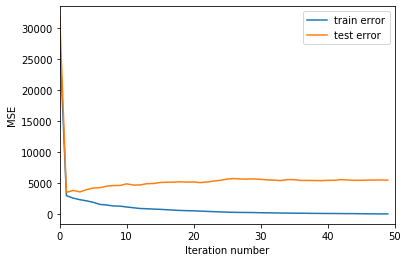

In [17]:
get_error_plot(n_trees, train_errors, test_errors)

Теперь попробуем уменьшить шаг.

In [18]:
eta = 0.1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [19]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 1424.9974471001462
Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 3317.777289095805


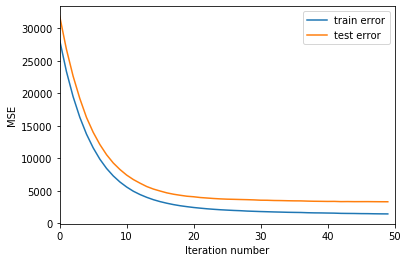

In [20]:
get_error_plot(n_trees, train_errors, test_errors)

Видим, что качество обучения улучшается.

Уменьшим шаг до 0.01.

In [21]:
eta = 0.01

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [22]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.01 на тренировочной выборке: 12024.359693527374
Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.01 на тестовой выборке: 14498.631070233347


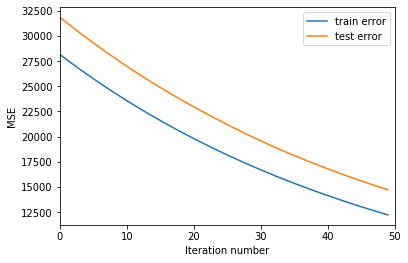

In [23]:
get_error_plot(n_trees, train_errors, test_errors)

При таком размере шага алгоритм сходится, но ему для достижения удовлетворительных показателей требуется большее количество итераций.

Вернемся к шагу 0.1 и попробуем увеличить глубину деревьев

In [24]:
eta = 0.1
max_depth = 5

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [25]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 50 деревьев глубиной 5     с шагом 0.1 на тренировочной выборке: 307.8909296395018
Ошибка алгоритма из 50 деревьев глубиной 5     с шагом 0.1 на тестовой выборке: 3707.4267604477973


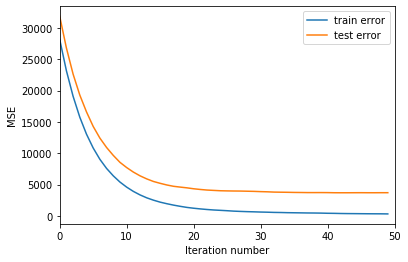

In [26]:
get_error_plot(n_trees, train_errors, test_errors)

В целом, тут мы показали, что варьируя параметры обучения градиентного бустинга можно добиваться различного уровня точности модели.

In [69]:
import pandas as pd
max_depth_list = [2,3,4,5,6,7,8,9,10]
trees_list = []
train_errors_list = []
test_errors_list = []
result_depth_list = []
result_n_list = []
for i in max_depth_list:
    n_trees_list = [5,10,20,30,50,100]
    coefs = [1] * n_trees
    eta_list = [1,0.5,0.1,0.01]
    for ii in n_trees_list:
        for iii in eta_list:
            trees, train_errors, test_errors = gb_fit(ii, i, X_train, X_test, y_train, y_test, coefs, iii)
            for z in train_errors:
                train_errors_list.append(z)
                result_depth_list.append(i)
                result_n_list.append(ii)
            for z in test_errors:
                test_errors_list.append(z)
            for z in trees:
                trees_list.append(z)

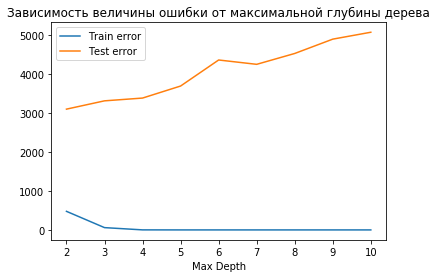

In [70]:
df_depth_results = pd.DataFrame([result_depth_list,train_errors_list,test_errors_list]).T.rename(columns = {0:'Max Depth',1:'Train error',2:'Test error'})
df_depth_results.groupby('Max Depth').min().plot()
plt.title('Зависимость величины ошибки от максимальной глубины дерева')
plt.show()

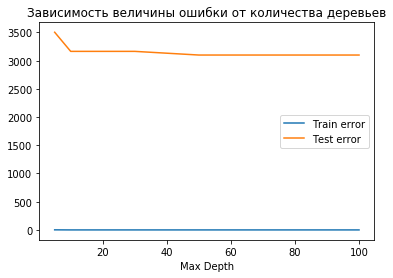

In [71]:
df_n_results = pd.DataFrame([result_n_list,train_errors_list,test_errors_list]).T.rename(columns = {0:'Max Depth',1:'Train error',2:'Test error'})
df_n_results.groupby('Max Depth').min().plot()
plt.title('Зависимость величины ошибки от количества деревьев')
plt.show()

### II. Стохастический градиент

In [44]:
def calc_mse(y, y_pred):
    err = np.mean((y - y_pred)**2)
    return err
# стохастический GS
def eval_sgd_model(X, y, iterations, qty_in_batch, alpha=1e-4):
    W = np.random.randn(X.shape[0])
    n = X.shape[1]
    n_batch = n // qty_in_batch
    
    if n % qty_in_batch != 0:
        n_batch += 1
        
    for i in range(1, iterations+1):
        for b in range(n_batch):
            start_ = qty_in_batch*b
            end_ = qty_in_batch*(b+1)
#             print(b, n_batch, start_, end_)
            X_tmp = X[:, start_ : end_]
            y_tmp = y[start_ : end_]

            y_pred_tmp = np.dot(W, X_tmp)
            err = calc_mse(y_tmp, y_pred_tmp)

            W -= (alpha * (1/n * 2 * np.dot((y_pred_tmp - y_tmp), X_tmp.T)))
        
#         if i % (iterations / 10) == 0:
#             print(i, W, err)
    return W

coef = eval_sgd_model(X_train, y_train, iterations=1000, qty_in_batch=5, alpha=1e-2)
# print(coef)

In [54]:
import pandas as pd
max_depth_list = [2,3,4]
trees_list = []
train_errors_list = []
test_errors_list = []
result_depth_list = []
result_n_list = []
result_iters_list = []
iteraсtions_list = [50,500,1000]
for i in max_depth_list:
    n_trees_list = [5,10]
    eta_list = [1]
    for ii in n_trees_list:
        for iii in eta_list:
            for iiii in iterations_list:
                coef = eval_sgd_model(X_train, y_train, iteraсtions=iiii, qty_in_batch=5, alpha=1e-2)
#                 уменьшение кол-ва итераций - беру каждый 10й коэффициент
                for coef_i in coef[::10]:
                    coefs = [coef_i] * n_trees
                    trees, train_errors, test_errors = gb_fit(ii, i, X_train, X_test, y_train, y_test, coefs, iii)
                    for z in train_errors:
                        train_errors_list.append(z)
                        result_depth_list.append(i)
                        result_n_list.append(ii)
                        result_iters_list.append(iiii)
                    for z in test_errors:
                        test_errors_list.append(z)
                    for z in trees:
                        trees_list.append(z)
        print(i)

2
2
3
3
4
4


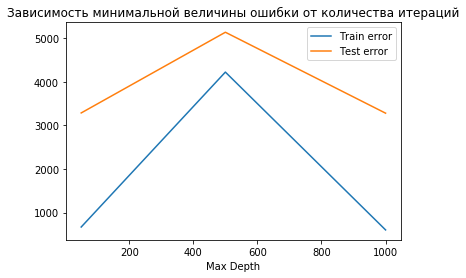

In [59]:
df_depth_results = pd.DataFrame([result_iters_list,train_errors_list,test_errors_list]).T.rename(columns = {0:'Max Depth',1:'Train error',2:'Test error'})
df_depth_results.groupby('Max Depth').min().plot()
plt.title('Зависимость минимальной величины ошибки от количества итераций')
plt.show()